#自定义训练：演示

本指南使用机器学习按品种对鸢尾花进行分类。它利用TensorFlow的Eager Execution来执行以下操作：1。构建模型，2。使用样本数据训练该模型，以及3.利用该模型对未知数据进行预测。

##TensorFlow编程
本指南采用了以下高级TensorFlow概念：

- 启用Eager Execution开发环境，
- 使用数据集API导入数据，
- 使用TensorFlow的Keras API构建模型和层。

本教程采用了与许多TensorFlow程序相似的结构：

1. 导入和解析数据集。
2. 选择模型类型。
3. 训练模型。
4. 评估模型的效果。
5. 使用经过训练的模型进行预测。

##设置程序

配置导入和Eager Execution

导入所需的Python模块（包括TensorFlow），然后针对此程序启用Eager Execution。借助Eager Execution，TensorFlow会立即评估各项操作，并返回具体的值，而不是创建稍后执行的计算图。如果您习惯使用REPL或python交互控制台，对于Eager Execution您会用起来得心应手.TensorFlow 1.8及以上版本中提供了Eager Execution。

Eager Execution一旦启用，便无法在同一程序中停用。如需了解详情，请参阅Eager Execution指南。



In [2]:
from __future__ import  absolute_import , division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.14.0
Eager execution: True


## 鸢尾花分类问题
想象一下，您是一名植物学家，正在寻找一种能够对所发现的每株鸢尾花进行自动归类的方法。机器学习可提供多种从统计学上分类花卉的算法。例如，一个复杂的机器学习程序可以根据照片对花卉进行分类。我们的要求并不高 - 我们将根据鸢尾花花萼和花瓣的长度和宽度对其进行分类。

鸢尾属约有 300 个品种，但我们的程序将仅对下列三个品种进行分类：

- 山鸢尾
- 维吉尼亚鸢尾
- 变色鸢尾

---
![图片](https://www.tensorflow.org/images/iris_three_species.jpg)

---

幸运的是，有人已经创建了一个包含 120 株鸢尾花的数据集（其中有花萼和花瓣的测量值）。这是一个在入门级机器学习分类问题中经常使用的经典数据集。

## 导入和解析训练数据集
下载数据集文件并将其转换为可供此 Python 程序使用的结构。

###下载数据集
使用 tf.keras.utils.get_file 函数下载训练数据集文件。该函数会返回下载文件的文件路径。



In [3]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                          origin=train_dataset_url)
print("Local copy of the dataset file:{}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file:/root/.keras/datasets/iris_training.csv


##检查数据
数据集 iris_training.csv 是一个纯文本文件，其中存储了逗号分隔值 (CSV) 格式的表格式数据。请使用 head -n5 命令查看前 5 个条目：

In [4]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


我们可以从该数据集视图中注意到以下信息：

1. 第一行是标题，其中包含数据集信息：
    - 共有 120 个样本。每个样本都有四个特征和一个标签名称，标签名称有三种可能。
2. 后面的行是数据记录，每个**样本**各占一行，其中：
    - 前四个字段是**特征**：即样本的特点。在此数据集中，这些字段存储的是代表花卉测量值的浮点数。
    - 最后一列是**标签**：即我们想要预测的值。对于此数据集，该值为 0、1 或 2 中的某个整数值（每个值分别对应一个花卉名称）。
    
我们用代码表示出来：

In [5]:
# column order in CSV file
column_names = ['sepal_length','sepal_width','petal_length','petal_width','species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features:{}".format(feature_names))
print("Label:{}".format(label_name))

Features:['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label:species


每个标签都分别与一个字符串名称（例如“setosa”）相关联，但机器学习通常依赖于数字值。标签编号会映射到一个指定的表示法，例如：

  - 0：山鸢尾
  - 1：变色鸢尾
  - 2：维吉尼亚鸢尾
  
如需详细了解特征和标签，请参阅[《机器学习速成课程》的“机器学习术语”部分](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology)。

In [0]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

###创建一个 tf.data.Dataset
TensorFlow 的 [Dataset API](https://www.tensorflow.org/guide/datasets) 可处理在向模型加载数据时遇到的许多常见情况。这是一种高阶 API，用于读取数据并将其转换为可供训练使用的格式。如需了解详情，请参阅[数据集快速入门指南](https://www.tensorflow.org/get_started/datasets_quickstart)。

由于数据集是 CSV 格式的文本文件，请使用 [make_csv_dataset](https://www.tensorflow.org/api_docs/python/tf/contrib/data/make_csv_dataset) 函数将数据解析为合适的格式。由于此函数为训练模型生成数据，默认行为是对数据进行随机处理 (shuffle=True, shuffle_buffer_size=10000)，并且无限期重复数据集 (num_epochs=None)。我们还设置了 [batch_size](https://developers.google.com/machine-learning/glossary/#batch_size) 参数。

In [8]:
batch_size = 32

train_dataset = tf.contrib.data.make_csv_dataset(train_dataset_fp,
                                                batch_size,
                                                column_names=column_names,
                                                label_name=label_name,
                                                num_epochs=1)

W0902 07:35:14.251796 140397121673088 deprecation.py:323] From <ipython-input-8-f33b5ae69744>:7: make_csv_dataset (from tensorflow.contrib.data.python.ops.readers) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.experimental.make_csv_dataset(...)`.
W0902 07:35:14.391916 140397121673088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/data/experimental/ops/readers.py:499: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


`make_csv_dataset` 函数返回 `(features, label)` 对的` tf.data.Dataset`，其中` features `是一个字典：`{'feature_name': value}`

启用 Eager Execution 后，这些 `Dataset `对象便可迭代。我们来看看一批特征：

In [9]:
features,labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
              array([5.7, 6.2, 5.1, 6.5, 5.7, 5.8, 5.5, 7.9, 6.1, 5. , 5.7, 5.5, 4.8,
                     5.5, 6.5, 4.4, 5.1, 6.3, 6.1, 6.9, 4.7, 5. , 5. , 5.1, 6.6, 6.4,
                     6.3, 6.5, 6.7, 6.2, 5.1, 6.4], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([2.9, 2.2, 3.7, 2.8, 3. , 4. , 3.5, 3.8, 2.6, 3.4, 2.8, 2.4, 3.4,
                     2.6, 3. , 2.9, 2.5, 2.5, 3. , 3.1, 3.2, 3.4, 3.3, 3.5, 2.9, 3.1,
                     2.7, 3. , 3.1, 2.8, 3.8, 2.7], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
              array([4.2, 4.5, 1.5, 4.6, 4.2, 1.2, 1.3, 6.4, 5.6, 1.6, 4.1, 3.7, 1.6,
                     4.4, 5.8, 1.4, 3. , 5. , 4.9, 5.1, 1.6, 1.5, 1.4, 1.4, 4.6, 5.5,
                     4.9, 5.2, 4.4, 4.8, 1.9, 5.3],

请注意，类似特征会归为一组，即分为一批。每个样本行的字段都会附加到相应的特征数组中。更改 batch_size 可设置存储在这些特征数组中的样本数。

绘制该批次中的几个特征后，就会开始看到一些集群现象：

Text(0, 0.5, 'Sepal length')

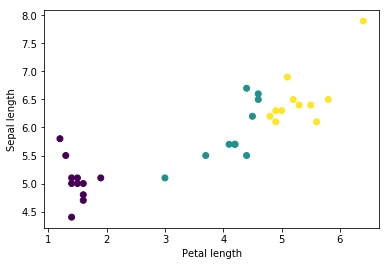

In [10]:
plt.scatter(features['petal_length'],
           features['sepal_length'],
           c=labels,
           cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")

要简化模型构建步骤，请创建一个函数以将特征字典重新打包为形状为 (batch_size, num_features) 的单个数组。

此函数使用 [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) 方法，该方法从张量列表中获取值，并创建指定维度的组合张量。

In [0]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()),axis=1)
  return features,labels

然后使用 [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) 方法将每个 `(features,label)` 对的 `features` 打包到训练数据集中：

In [0]:
train_dataset = train_dataset.map(pack_features_vector)

`Dataset` 的 features 元素现在是形状为` (batch_size, num_features)` 的数组。我们来看看前几个样本：

In [13]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[5.7 2.9 4.2 1.3]
 [6.2 2.2 4.5 1.5]
 [5.1 3.7 1.5 0.4]
 [6.5 2.8 4.6 1.5]
 [5.7 3.  4.2 1.2]], shape=(5, 4), dtype=float32)


##选择模型类型
###为何要使用模型？
[模型](https://developers.google.com/machine-learning/crash-course/glossary#model)是指特征与标签之间的关系。对于鸢尾花分类问题，模型定义了花萼和花瓣测量值与预测的鸢尾花品种之间的关系。一些简单的模型可以用几行代数进行描述，但复杂的机器学习模型拥有大量难以汇总的参数。

您能否在不使用机器学习的情况下确定四个特征与鸢尾花品种之间的关系？也就是说，您能否使用传统编程技巧（例如大量条件语句）创建模型？也许能，前提是反复分析该数据集，并最终确定花瓣和花萼测量值与特定品种的关系。对于更复杂的数据集来说，这会变得非常困难，或许根本就做不到。一个好的机器学习方法可为您确定模型。如果您将足够多的代表性样本馈送到正确类型的机器学习模型中，该程序便会为您找出相应的关系。

###选择模型
我们需要选择要进行训练的模型类型。模型具有许多类型，挑选合适的类型需要一定的经验。本教程使用神经网络来解决鸢尾花分类问题。[神经网络](https://developers.google.com/machine-learning/glossary/#neural_network)可以发现特征与标签之间的复杂关系。神经网络是一个高度结构化的图，其中包含一个或多个[隐藏层](https://developers.google.com/machine-learning/glossary/#hidden_layer)。每个隐藏层都包含一个或多个[神经元](https://developers.google.com/machine-learning/glossary/#neuron)。神经网络有多种类别，该程序使用的是密集型神经网络，也称为[全连接神经网络](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)：一个层中的神经元将从上一层中的每个神经元获取输入连接。例如，图 2 显示了一个密集型神经网络，其中包含 1 个输入层、2 个隐藏层以及 1 个输出层：

---
![图片](https://www.tensorflow.org/images/custom_estimators/full_network.png)

---
图 2. 包含特征、隐藏层和预测的神经网络
 
 ---
 当图 2 中的模型经过训练并获得无标签样本后，它会产生 3 个预测结果：相应鸢尾花属于指定品种的可能性。这种预测称为[推理](https://developers.google.com/machine-learning/crash-course/glossary#inference)。对于该示例，输出预测结果的总和是 1.0。在图 2 中，该预测结果分解如下：山鸢尾为 0.02，变色鸢尾为 0.95，维吉尼亚鸢尾为 0.03。这意味着该模型预测某个无标签鸢尾花样本是变色鸢尾的概率为 95％。

##使用 Keras 创建模型
TensorFlow[ tf.keras ](https://www.tensorflow.org/api_docs/python/tf/keras)API 是创建模型和层的首选方式。通过该 API，您可以轻松地构建模型并进行实验，而将所有部分连接在一起的复杂工作则由 Keras 处理。

[tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) 模型是层的线性堆叠。该模型的构造函数会采用一系列层实例；在本示例中，采用的是 2 个[密集层](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)（分别包含 10 个节点）以及 1 个输出层（包含 3 个代表标签预测的节点）。第一个层的 input_shape 参数对应该数据集中的特征数量，它是一项必需参数。


In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)), # input shape required
    tf.keras.layers.Dense(10,activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

[激活函数](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)可决定层中每个节点的输出形状。这些非线性关系很重要，如果没有它们，模型将等同于单个层。[激活函数](https://www.tensorflow.org/api_docs/python/tf/keras/activations)有很多，但隐藏层通常使用 [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU)。

隐藏层和神经元的理想数量取决于问题和数据集。与机器学习的多个方面一样，选择最佳的神经网络形状需要一定的知识水平和实验基础。一般来说，增加隐藏层和神经元的数量通常会产生更强大的模型，而这需要更多数据才能有效地进行训练。

##使用模型
我们快速了解一下此模型如何处理一批特征：

In [15]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=234, shape=(5, 3), dtype=float32, numpy=
array([[ 0.73128784, -0.20539331,  1.3644929 ],
       [ 0.5985209 , -0.20459408,  1.4556589 ],
       [ 0.04352212, -0.6136578 ,  1.2841328 ],
       [ 0.65912175, -0.22795856,  1.542766  ],
       [ 0.74128056, -0.20326746,  1.3778706 ]], dtype=float32)>

在此示例中，每个样本针对每个类别返回一个[对数](https://developers.google.com/machine-learning/crash-course/glossary#logit)。

要将这些对数转换为每个类别的概率，请使用 [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) 函数：

In [16]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=240, shape=(5, 3), dtype=float32, numpy=
array([[0.30529088, 0.11965156, 0.5750575 ],
       [0.2628578 , 0.11774228, 0.61939996],
       [0.20096321, 0.10416143, 0.6948754 ],
       [0.26099044, 0.1074906 , 0.63151896],
       [0.30498216, 0.11859392, 0.5764239 ]], dtype=float32)>

对每个类别执行` tf.argmax `运算可得出预测的类别索引。不过，该模型尚未接受训练，因此这些预测并不理想。

In [18]:
print("Prediction:{}".format(tf.argmax(predictions,axis=1)))
print("    Labels:{}".format(labels))

Prediction:[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
    Labels:[1 1 0 1 1 0 0 2 2 0 1 1 0 1 2 0 1 2 2 2 0 0 0 0 1 2 2 2 1 2 0 2]


## 训练模型
[训练](https://developers.google.com/machine-learning/crash-course/glossary#training)是一个机器学习阶段，在此阶段中，模型会逐渐得到优化，也就是说，模型会了解数据集。目标是充分了解训练数据集的结构，以便对未见过的数据进行预测。如果您从训练数据集中获得了过多的信息，预测便会仅适用于模型见过的数据，但是无法泛化。此问题称为[过拟合](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)，好比将答案死记硬背下来，而不去理解问题的解决方式。

鸢尾花分类问题是[监督式机器学习](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)的一个示例：模型通过包含标签的样本加以训练。在[非监督式机器学习](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)中，样本不包含标签。相反，模型通常会在特征中发现一些规律。

###定义损失和梯度函数
在训练和评估阶段，我们都需要计算模型的[损失](https://developers.google.com/machine-learning/crash-course/glossary#loss)。这样可以衡量模型的预测结果与预期标签有多大偏差，也就是说，模型的效果有多差。我们希望尽可能减小或优化这个值。

我们的模型会使用 [tf.losses.sparse_softmax_cross_entropy ](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy)函数计算其损失，此函数会接受模型的类别概率预测结果和预期标签，然后返回样本的平均损失。

In [19]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test:{}".format(l))

Loss test:1.4363584518432617


使用 [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) context 计算用于优化模型的[梯度](https://developers.google.com/machine-learning/crash-course/glossary#gradient)。有关更多相关示例，请参阅 [Eager Execution](https://www.tensorflow.org/guide/eager) 指南。

In [0]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
    
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

##创建优化器
[优化器](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)会将计算出的梯度应用于模型的变量，以最小化 loss 函数。您可以将损失函数想象为一个曲面（见图 3），我们希望通过到处走动找到该曲面的最低点。梯度指向最高速上升的方向，因此我们将沿相反的方向向下移动。我们以迭代方式计算每个批次的损失和梯度，以在训练过程中调整模型。模型会逐渐找到权重和偏差的最佳组合，从而将损失降至最低。损失越低，模型的预测效果就越好。

---
![图片](https://cs231n.github.io/assets/nn3/opt1.gif)

---
图 3. 优化算法在三维空间中随时间推移而变化的可视化效果。（来源：斯坦福大学 CS231n 课程，MIT 许可证）

----

TensorFlow 拥有许多可用于训练的[优化算法](https://www.tensorflow.org/api_guides/python/train)。此模型使用的是 [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer)，它可以实现[随机梯度下降法](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent) (SGD)。learning_rate 用于设置每次迭代（向下行走）的步长。这是一个超参数，您通常需要调整此参数以获得更好的结果。

我们来设置优化器和 `global_step` 计数器：

In [0]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.train.get_or_create_global_step()

我们将使用它来计算单个优化步骤：

In [23]:
loss_value, grads = grad(model, features, labels)
print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                         loss_value.numpy()))
optimizer.apply_gradients(zip(grads, model.variables),global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                         loss(model, features, labels).numpy()))

Step: 1, Initial Loss: 1.371757984161377
Step: 2,         Loss: 1.3233377933502197


##训练循环
一切准备就绪后，就可以开始训练模型了！训练循环会将数据集样本馈送到模型中，以帮助模型做出更好的预测。以下代码块可设置这些训练步骤：

1. 迭代每个周期。通过一次数据集即为一个周期。
2. 在一个周期中，遍历训练 Dataset 中的每个样本，并获取样本的特征 (`x`) 和标签 (`y`)。
3. 根据样本的特征进行预测，并比较预测结果和标签。衡量预测结果的不准确性，并使用所得的值计算模型的损失和梯度。
4. 使用 optimizer 更新模型的变量。
5. 跟踪一些统计信息以进行可视化。
6. 对每个周期重复执行以上步骤。
`num_epochs` 变量是遍历数据集集合的次数。与直觉恰恰相反的是，训练模型的时间越长，并不能保证模型就越好。`num_epochs` 是一个可以调整的[超参数](https://developers.google.com/machine-learning/glossary/#hyperparameter)。选择正确的次数通常需要一定的经验和实验基础。

In [25]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting

train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()
  
  # Training loop - using batches of 32
  for x, y in train_dataset:
    #Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                             global_step)
    
    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label toactual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)
    
  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 50 ==0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                               epoch_loss_avg.result(),
                                                               epoch_accuracy.result()))

Epoch 000: Loss: 1.145, Accuracy: 35.000%
Epoch 050: Loss: 0.359, Accuracy: 92.500%
Epoch 100: Loss: 0.249, Accuracy: 96.667%
Epoch 150: Loss: 0.187, Accuracy: 97.500%
Epoch 200: Loss: 0.157, Accuracy: 96.667%


###可视化损失函数随时间推移而变化的情况
虽然输出模型的训练过程有帮助，但查看这一过程往往更有帮助。[TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) 是与 TensorFlow 封装在一起的出色可视化工具，不过我们可以使用 `matplotlib` 模块创建基本图表。

解读这些图表需要一定的经验，不过您确实希望看到损失下降且准确率上升。

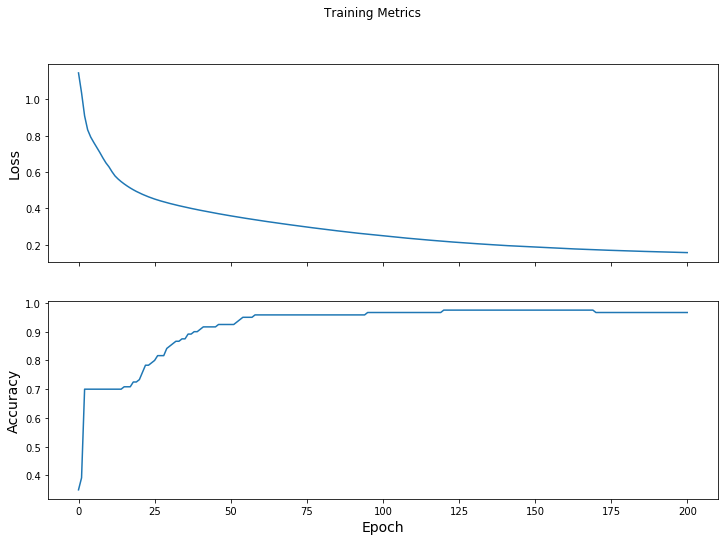

In [27]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle("Training Metrics")

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

##评估模型的效果
模型已经过训练，现在我们可以获取一些关于其效果的统计信息了。

评估指的是确定模型做出预测的效果。要确定模型在鸢尾花分类方面的效果，请将一些花萼和花瓣测量值传递给模型，并要求模型预测它们所代表的鸢尾花品种。然后，将模型的预测结果与实际标签进行比较。例如，如果模型对一半输入样本的品种预测正确，则准确率为 0.5。图 4 显示的是一个效果更好一些的模型，该模型做出 5 次预测，其中有 4 次正确，准确率为 80%：


##设置测试数据集
评估模型与训练模型相似。最大的区别在于，样本来自一个单独的测试集，而不是训练集。为了公正地评估模型的效果，用于评估模型的样本务必与用于训练模型的样本不同。

测试 Dataset 的设置与训练 Dataset 的设置相似。下载 CSV 文本文件并解析相应的值，然后对数据稍加随机化处理：

In [28]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"
test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                 origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [0]:
test_dataset = tf.contrib.data.make_csv_dataset(train_dataset_fp,
                                                  batch_size,
                                                  column_names=column_names,
                                                  label_name='species',
                                                  num_epochs=1,
                                                  shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

###根据测试数据集评估模型
与训练阶段不同，模型仅评估测试数据的一个周期。在以下代码单元格中，我们会遍历测试集中的每个样本，然后将模型的预测结果与实际标签进行比较。这是为了衡量模型在整个测试集中的准确率。

In [33]:
test_accuracy = tfe.metrics.Accuracy()

for(x,y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction,y)
  
print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 95.833%


例如，我们可以看到对于最后一批数据，该模型通常预测正确：

In [34]:
tf.stack([y,prediction], axis=1)

<tf.Tensor: id=106457, shape=(24, 2), dtype=int32, numpy=
array([[0, 0],
       [2, 2],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [0, 0],
       [0, 0],
       [1, 1]], dtype=int32)>

##使用经过训练的模型进行预测
我们已经训练了一个模型并“证明”它是有效的，但在对鸢尾花品种进行分类方面，这还不够。现在，我们使用经过训练的模型对无标签样本（即包含特征但不包含标签的样本）进行一些预测。

在现实生活中，无标签样本可能来自很多不同的来源，包括应用、CSV 文件和数据 Feed。暂时我们将手动提供三个无标签样本以预测其标签。回想一下，标签编号会映射到一个指定的表示法：

- 0：山鸢尾
- 1：变色鸢尾
- 2：维吉尼亚鸢尾

In [35]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predicttions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris virginica (57.5%)
Example 1 prediction: Iris virginica (61.9%)
Example 2 prediction: Iris virginica (69.5%)
Example 3 prediction: Iris virginica (63.2%)
Example 4 prediction: Iris virginica (57.6%)
Example 5 prediction: Iris virginica (77.1%)
Example 6 prediction: Iris virginica (75.1%)
Example 7 prediction: Iris virginica (60.4%)
Example 8 prediction: Iris virginica (52.2%)
Example 9 prediction: Iris virginica (68.6%)
Example 10 prediction: Iris virginica (58.5%)
Example 11 prediction: Iris virginica (61.2%)
Example 12 prediction: Iris virginica (67.3%)
Example 13 prediction: Iris virginica (54.7%)
Example 14 prediction: Iris virginica (50.8%)
Example 15 prediction: Iris virginica (65.6%)
Example 16 prediction: Iris virginica (60.9%)
Example 17 prediction: Iris virginica (57.2%)
Example 18 prediction: Iris virginica (54.4%)
Example 19 prediction: Iris virginica (60.1%)
Example 20 prediction: Iris virginica (66.7%)
Example 21 prediction: Iris virginica (69.8%